In [10]:
!pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.7.0
    Uninstalling imbalanced-learn-0.7.0:
      Successfully uninstalled imbalanced-learn-0.7.0


In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree


In [12]:
df = pd.read_csv("card_transdata - with sample ID.csv")
df = df.dropna(axis=1, how='any')
df.head()


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


In [31]:
print('Raw counts: \n')
print(df['fraud'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['fraud'].value_counts(normalize=True))

Raw counts: 

0    912597
1     87403
Name: fraud, dtype: int64
-----------------------------------
Normalized counts: 

0    0.912597
1    0.087403
Name: fraud, dtype: float64


#As you see, there is a huge imbalance of data so we need to fix that. Let's try SMOTE

In [32]:
X = df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order',]]
y = df[['fraud']]
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

LogisticRegression(C=1e+20, fit_intercept=False)
AUC for None: 0.8702960680967472
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', fit_intercept=False)
AUC for Balanced: 0.9463024157152584
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 2}, fit_intercept=False)
AUC for 2 to 1: 0.9102491329135606
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 10}, fit_intercept=False)
AUC for 10 to 1: 0.9457952958584717
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 100}, fit_intercept=False)
AUC for 100 to 1: 0.9614413825229513
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weig

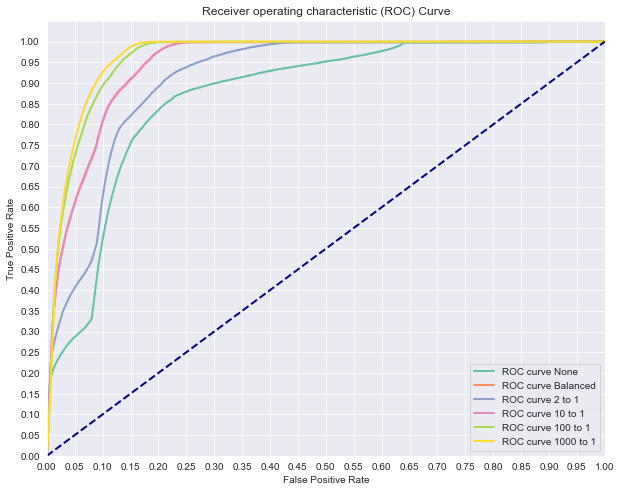

In [34]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
from imblearn.over_sampling import SMOTE

In [38]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())

Original class distribution: 

fraud
0        912597
1         87403
dtype: int64


In [44]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                     int64
used_chip                           int64
used_pin_number                     int64
online_order                        int64
fraud                               int64
dtype: object

In [47]:
smote = SMOTE (sampling_strategy = 'minority')

In [48]:
X_sm, y_sm = smote.fit_resample(X,y)


In [51]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X, y) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(y_sm.value_counts())

Original class distribution: 

fraud
0        912597
1         87403
dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

fraud
1        912597
0        912597
dtype: int64


In [52]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth= 3)

clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

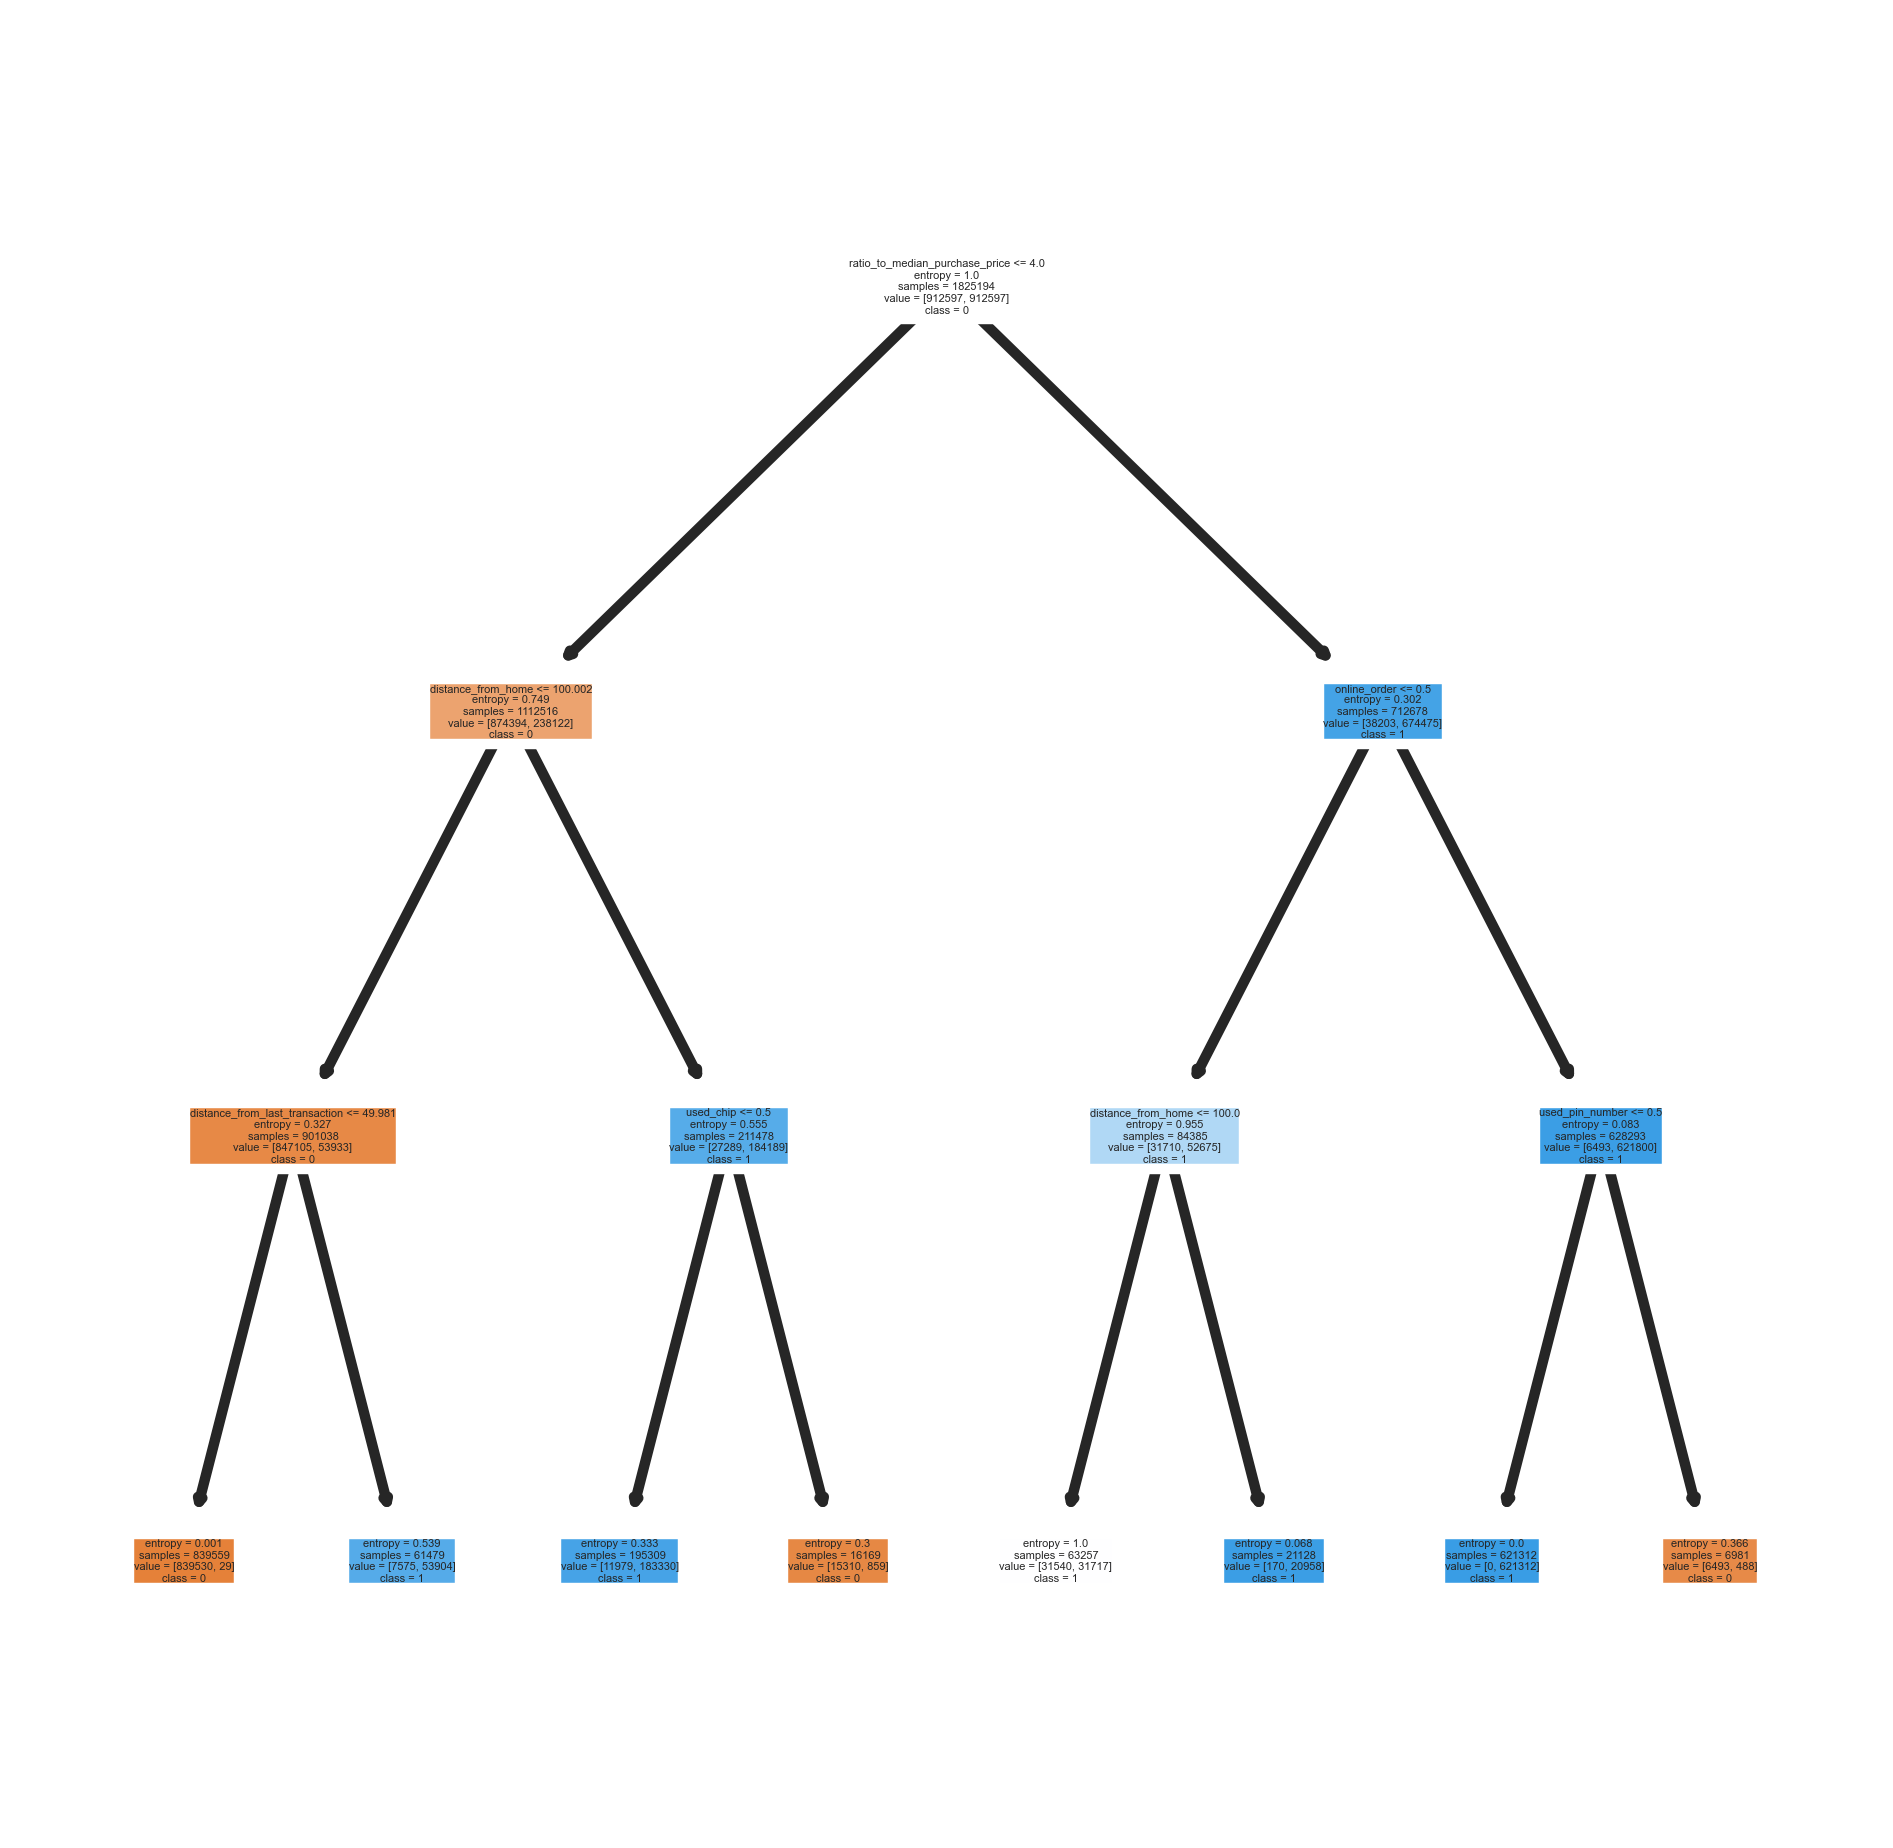

In [53]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=750)
tree.plot_tree(clf,
               feature_names = X_train.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [25]:
y_preds = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.97833


In [28]:
from sklearn import metrics
recall = metrics.recall_score(y_test, y_preds)
print('Recall:', recall)

Recall: 0.9130850778828122
